In [23]:
!which python 
!whoami 
!hostname
!pwd

/home/farshed.abdukhakimov/miniconda3/envs/main/bin/python
farshed.abdukhakimov
srv-01
/home/farshed.abdukhakimov/projects/SANIA


In [24]:
%load_ext autoreload
%autoreload 2

import os
import datetime
import time
from collections import defaultdict

import numpy as np
import numba

from sklearn.model_selection import train_test_split

import matplotlib.pyplot as plt

from experiments import utils
from experiments.loss_functions import LogisticRegressionLoss, BaseOracle
from experiments.methods import *

import scipy
# import optuna 

import svmlight_loader

from dotenv import load_dotenv
load_dotenv()

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


True

In [25]:
np.random.seed(0)
n = 10000
d = 200

data, target = utils.make_synthetic_binary_classification(n, d)
train_data, test_data, train_target, test_target = train_test_split(data, target, test_size=0.2, random_state=0)

scale = 4
scaling_vec = utils.generate_scaling_vec(size=train_data.shape[1], scale=scale)
scaled_train_data = scaling_vec * train_data
scaled_test_data = scaling_vec * test_data

dataset = train_data, train_target, test_data, test_target
scaled_dataset = scaled_train_data, train_target, scaled_test_data, test_target

In [26]:
def train_loop(dataset: list[np.ndarray], 
               batch_size: int, 
               n_epochs: int,
               optimizer:BaseOptimizer,
               seed: int = 0,
               **optimizer_kwargs) -> dict: 

    np.random.seed(seed)
    
    train_data, train_target, test_data, test_target = dataset
    
    # parameters
    params = np.zeros(train_data.shape[1])
    optim = optimizer(params, **optimizer_kwargs)

    # oracle 
    loss_function = LogisticRegressionLoss()
    
    # logging 
    history = defaultdict(list)

    indices = np.arange(train_data.shape[0])
    
    for epoch in range(n_epochs):
        
        # Evaluation 
        loss, grad, acc = loss_function.func_grad_acc(params, test_data, test_target)
        g_norm = np.linalg.norm(grad)**2
        history["test/loss"].append(loss)
        history["test/acc"].append(acc)
        history["test/grad_norm"].append(g_norm)
        

        # Training 
        np.random.shuffle(indices)

        for idx in range(train_data.shape[0]//batch_size):
            batch_indices = indices[idx*batch_size:(idx+1)*batch_size]
            batch_data = train_data[batch_indices]
            batch_target = train_target[batch_indices] 
        
            train_loss, train_grad, _ = loss_function.func_grad_acc(params, batch_data, batch_target)
            
            optim.step(loss=train_loss, grad=train_grad)
            
        # print(f"Epoch [{epoch}/{n_epochs}] | Train Loss: {epoch_loss} | Val Loss: {val_loss}")
        # print(f"Val GradNorm**2: {val_g_norm} | Train GradNorm**2: {epoch_grad_norm}")
        # print(f"Val Acc: {val_acc} | Train Acc: {epoch_acc}\n")
        
        
    # Evaluation 
    loss, grad, acc = loss_function.func_grad_acc(params, test_data, test_target)
    g_norm = np.linalg.norm(grad)**2
    history["test/loss"].append(loss)
    history["test/acc"].append(acc)
    history["test/grad_norm"].append(g_norm)
    
    # print(f"Test Loss: {test_loss} | Test Acc: {test_acc} | Test GradNorm**2: {test_g_norm}")
    
    return history

In [27]:
def plot_loss(dataset_name: str, batch_size: int, n_epochs: int, 
            model_name: str, methods: list[str], lrs: list[float], 
            scales: list[int], labels: list[str], colors=None,  
            linestyles=None, linewidths=None, 
            markers=None, markersizes=None,
            suptitle=None, ylabel="Test Loss",
            threshold=1e-10, tight_layout=True, filename=None):
    
    if suptitle is not None:
        plt.suptitle(suptitle, fontsize=16)
        
    if colors is None:
        colors = list(plt.cm.colors.XKCD_COLORS.keys())
        np.random.shuffle(colors)
        colors = list(plt.cm.colors.BASE_COLORS) + colors
        
    if linestyles is None:
        linestyles = ["-" for x in methods]
    
    if linewidths is None:
        linewidths = [1.5 for x in methods]
        
    if markers is None:
        markers = [" " for x in methods]
        
    for method, lr, scale, label, color, linestyle, linewidth, marker, ms in zip(methods, lrs, scales, labels, colors, linestyles, linewidths, markers, markersizes):
        hist_all = []
        for seed in range(5):
        
            hist = utils.load_results(dataset_name=dataset_name,
                                      model_name=model_name,
                                      scale=scale,
                                      batch_size=batch_size, 
                                      n_epochs=n_epochs,
                                      optimizer=method,
                                      lr=lr,
                                      seed=seed)
            hist_all.append(hist)
            
        loss = [x["test/loss"] for x in hist_all]
        
        mean_line = np.mean(loss, axis=0)
        max_line = np.max(loss, axis=0)
        min_line = np.min(loss, axis=0)

        x = np.linspace(0, mean_line.shape[0] - 1, mean_line.shape[0])
        markevery = [x + np.random.randint(0, 5) for x in range(0, len(loss[0]), len(loss[0]) // 10)][:-1]
        
        if scale == 0:
            label = f"{label:<20} (original data)"
        elif scale > 0:
            label = f"{label:<20} (scaled data)  "

        plt.fill_between(x, max_line, min_line, color=color, alpha=0.15) 
        plt.semilogy(x, mean_line, color=color, linestyle=linestyle, linewidth=linewidth, marker=marker, markersize=ms, markevery=markevery, label=label)
        
        
        
    plt.xlabel("Epochs", fontsize=14)
    plt.ylabel(f"{ylabel}", fontsize=14)

    
    # from matplotlib.lines import Line2D
    # legend_elements = [Line2D([0], [0], linestyle="-", color="k", label='Original data'),
    #                 Line2D([0], [0], linestyle="--",  color='k', label='Scaled data')]
    # lg = plt.legend(handles=legend_elements, loc="center", bbox_to_anchor=(0., 0.25, 0.5, 0.5))
    # plt.gca().add_artist(lg)
    
    plt.legend()
    plt.grid()
    

    if tight_layout:
        plt.tight_layout()
        
    if filename is not None:

        directory = os.getenv("PLOTS_DIR") + "/" + datetime.datetime.today().strftime("%d-%m-%Y")
        if not os.path.exists(directory):
            os.makedirs(directory)
        
        plt.savefig(directory + "/" + filename)
    else:
        plt.show() 

In [5]:
n_epochs = 100
batch_size = 20

optimizers = [SANIA_AdagradSQR, SANIA_AdagradSQR, SANIA_AdagradSQR, SANIA_AdagradSQR, SANIA_AdamSQR, SANIA_AdamSQR, SANIA_AdamSQR, SANIA_AdamSQR]
sqrts = [True, True, False, False, True, True, False, False]
scales = [0, scale, 0, scale, 0, scale, 0, scale]

dataset_name = f"binary_classification_synthetic_{n}x{d}"
all_histories = []

for optimizer, sqrt, scale in zip(optimizers, sqrts, scales):
    
    if scale > 0:
        t_dataset = scaled_dataset
    else:
        t_dataset = dataset
        
    if sqrt:
        optimizer_name = optimizer.__name__[:-3]
    else:
        optimizer_name = optimizer.__name__
    
    print(optimizer_name)
    
    histories = []

    for seed in [0, 1, 2, 3, 4]:
        hist = train_loop(dataset=t_dataset, 
                        batch_size=batch_size, 
                        n_epochs=n_epochs, 
                        optimizer=optimizer,
                        seed=seed, 
                        eps=0.0, 
                        is_sqrt=sqrt,
                        )
        
        utils.save_results(results=hist, 
                           model_name="linear", 
                           dataset_name=dataset_name,
                           scale=scale, 
                           batch_size=batch_size,
                           n_epochs=n_epochs,
                           optimizer=optimizer_name,
                           lr=1.0,
                           seed=seed)
        
        histories.append(hist)
        
    all_histories.append(histories)

SANIA_Adagrad
Results saved to /home/farshed.abdukhakimov/results/SANIA/linear/binary_classification_synthetic_10000x200/scale_0/bs_20/epochs_100/SANIA_Adagrad/lr_1.0/seed_0
Results saved to /home/farshed.abdukhakimov/results/SANIA/linear/binary_classification_synthetic_10000x200/scale_0/bs_20/epochs_100/SANIA_Adagrad/lr_1.0/seed_1
Results saved to /home/farshed.abdukhakimov/results/SANIA/linear/binary_classification_synthetic_10000x200/scale_0/bs_20/epochs_100/SANIA_Adagrad/lr_1.0/seed_2
Results saved to /home/farshed.abdukhakimov/results/SANIA/linear/binary_classification_synthetic_10000x200/scale_0/bs_20/epochs_100/SANIA_Adagrad/lr_1.0/seed_3
Results saved to /home/farshed.abdukhakimov/results/SANIA/linear/binary_classification_synthetic_10000x200/scale_0/bs_20/epochs_100/SANIA_Adagrad/lr_1.0/seed_4
SANIA_Adagrad
Results saved to /home/farshed.abdukhakimov/results/SANIA/linear/binary_classification_synthetic_10000x200/scale_4/bs_20/epochs_100/SANIA_Adagrad/lr_1.0/seed_0
Results save

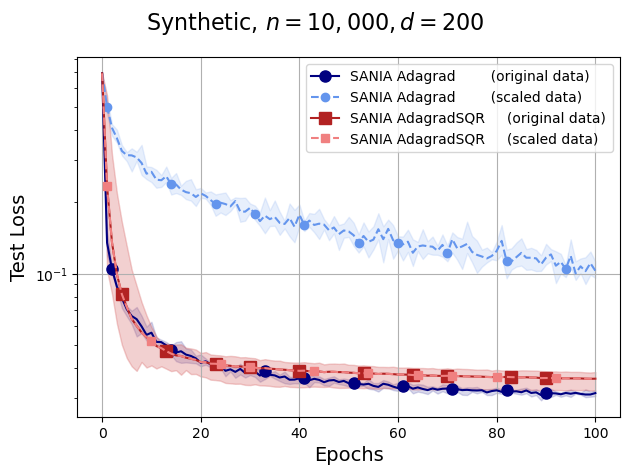

In [28]:
model_name = "linear"
n_epochs = 100
batch_size = 20
dataset_name = f"binary_classification_synthetic_{n}x{d}"


methods = ["SANIA_Adagrad", "SANIA_Adagrad", "SANIA_AdagradSQR", "SANIA_AdagradSQR"]
lrs = [1.0, 1.0, 1.0, 1.0, 1.0]

scales = [0, scale, 0, scale]
linestyles = ["-", "--", "-", "--"]

markers = ["o", "o", "s", "s"]
markersizes = [8, 6, 8, 6]

colors = ["navy", "cornflowerblue", "firebrick", "lightcoral", "orangered", "navy", "purple", "lime"]
linewidths = [1.5, 1.5, 1.5, 1.5, 1.0, 1.5, 1.5, 1.5]

suptitle = r"Synthetic, $n={0:,}, d={1}$".format(n, d)
labels = [r"SANIA Adagrad", r"SANIA Adagrad", r"SANIA AdagradSQR", r"SANIA AdagradSQR"]


plot_loss(dataset_name=dataset_name, 
        batch_size=batch_size,
        n_epochs=n_epochs, 
        model_name=model_name, 
        methods=methods, 
        lrs=lrs, 
        scales=scales, 
        labels=labels, 
        colors=colors, 
        linestyles=linestyles, 
        linewidths=linewidths, 
        markers=markers, 
        markersizes=markersizes,
        suptitle=suptitle, 
        threshold=0.0, 
        tight_layout=True, 
        filename=f"{dataset_name}_{model_name}_{batch_size}_SANIA_AdagradSQR.pdf"
        )

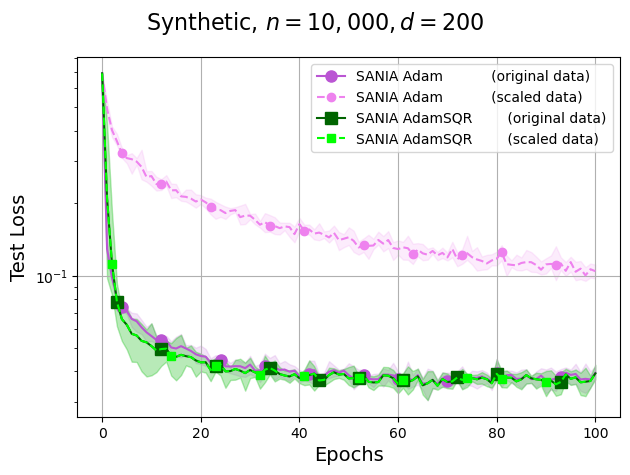

In [29]:
model_name = "linear"
n_epochs = 100
batch_size = 20
dataset_name = f"binary_classification_synthetic_{n}x{d}"


methods = ["SANIA_Adam", "SANIA_Adam", "SANIA_AdamSQR", "SANIA_AdamSQR"]
lrs = [1.0, 1.0, 1.0, 1.0, 1.0]
scales = [0, scale, 0, scale]
linestyles = ["-", "--", "-", "--"]

markers = ["o", "o", "s", "s"]
markersizes = [8, 6, 8, 6]

colors = ["mediumorchid", "violet", "darkgreen", "lime", "orangered", "navy", "purple", "lime"]
linewidths = [1.5, 1.5, 1.5, 1.5, 1.0, 1.5, 1.5, 1.5]
suptitle = r"Synthetic, $n={0:,}, d={1}$".format(n, d)
labels = ["SANIA Adam", "SANIA Adam", "SANIA AdamSQR", "SANIA AdamSQR"]

plot_loss(dataset_name=dataset_name, 
        batch_size=batch_size, 
        n_epochs=n_epochs, 
        model_name=model_name, 
        methods=methods, 
        lrs=lrs, 
        scales=scales, 
        labels=labels, 
        colors=colors, 
        linestyles=linestyles, 
        linewidths=linewidths, 
        markers=markers, 
        markersizes=markersizes,
        suptitle=suptitle, 
        threshold=0.0, 
        tight_layout=True, 
        filename=f"{dataset_name}_{model_name}_{batch_size}_SANIA_AdamSQR.pdf",
        )